In [ ]:
!pip install opendatasets --quiet
!pip install kaggle --quiet
import os
import json

# Kaggle API bilgileri (kendi bilgilerinle güncel)
kaggle_api = {
    "username": "yourUsername",
    "key": "yourKey"
}

# Kaggle JSON dosyası oluştur
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_api, f)
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
print("✅ Kaggle API yapılandırıldı.")


✅ Kaggle API yapılandırıldı.


In [ ]:
import opendatasets as od

# Veri setini indir
od.download("https://www.kaggle.com/datasets/orvile/bone-fracture-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: iremdeniz
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/orvile/bone-fracture-dataset


In [ ]:
import os
import shutil
import random
from tqdm import tqdm
from PIL import Image

# Klasörler
source_dir = "/content/bone-fracture-dataset/Bone fracture dataset/Bone fracture dataset/Dataset"
target_dir = "/content/bone-fracture-dataset/split_dataset"
classes = ['fracture', 'normal']
split_ratios = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Split için klasörleri oluştur
for split in split_ratios:
    for cls in classes:
        os.makedirs(os.path.join(target_dir, split, cls), exist_ok=True)

# Fracture ve Normal pathlerini al
fracture_images = [os.path.join(source_dir, 'fracture', img) for img in os.listdir(os.path.join(source_dir, 'fracture')) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
normal_images = [os.path.join(source_dir, 'normal', img) for img in os.listdir(os.path.join(source_dir, 'normal')) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Split fonksiyonu
def split_and_copy(file_paths, cls):
    random.seed(42)
    random.shuffle(file_paths)
    total = len(file_paths)
    train_end = int(split_ratios['train'] * total)
    val_end = train_end + int(split_ratios['val'] * total)

    splits = {
        'train': file_paths[:train_end],
        'val': file_paths[train_end:val_end],
        'test': file_paths[val_end:]
    }

    for split, files in splits.items():
        for path in tqdm(files, desc=f"{cls} -> {split}"):
            dest = os.path.join(target_dir, split, cls, os.path.basename(path))
            shutil.copy(path, dest)

# Split işlemi
split_and_copy(fracture_images, 'fracture')
split_and_copy(normal_images, 'normal')

print("✅ Dataset split edildi (henüz augment yok).")


normal -> test: 100%|██████████| 20/20 [00:00<00:00, 103.27it/s]

✅ Dataset split edildi (henüz augment yok).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

# Yollar
IMG_SIZE = 224
BATCH_SIZE = 32
train_path = f"{target_dir}/train"
val_path = f"{target_dir}/val"

# Data augmentation (sadece train için)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data loaders
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)

# İlk eğitim
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stop, lr_reduction]
)

# Modeli kaydet
model.save("bone_fracture_mobilenetv2_initial.h5")
print("✅ İlk eğitim bitti ve model kaydedildi.")


Found 1488 images belonging to 2 classes.
Found 319 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.5995 - loss: 0.7714 - precision: 0.0685 - recall: 0.4300 - val_accuracy: 0.8339 - val_loss: 0.5153 - val_precision: 0.1731 - val_recall: 0.4737 - learning_rate: 1.0000e-04
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 582ms/step - accuracy: 0.8210 - loss: 0.3976 - precision: 0.1220 - recall: 0.3571 - val_accuracy: 0.9467 - val_loss: 0.3058 - val_precision: 0.6250 - val_recall: 0.2632 - learning_rate: 1.0000e-04
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 587ms/step - accuracy: 0.9022 - loss: 0.2843 - precision: 0.1501 - recall: 0.2045 - val_accuracy: 0.9592 - val_loss: 0.2341 - val_precision: 1.0000 - val_recall: 0.3158 - learning_rate: 1.0000e-04
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 577ms/step - accuracy: 0.9209 - loss: 0.2384 - precision: 0.1918 - recall: 0.1453 - val_accuracy: 0.9592 - val_loss: 0.1864 - val_precision: 1.0000 - val_recall: 0.3158 - learning_rate: 1.0000e-04
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 57

✅ İlk eğitim bitti ve model kaydedildi.


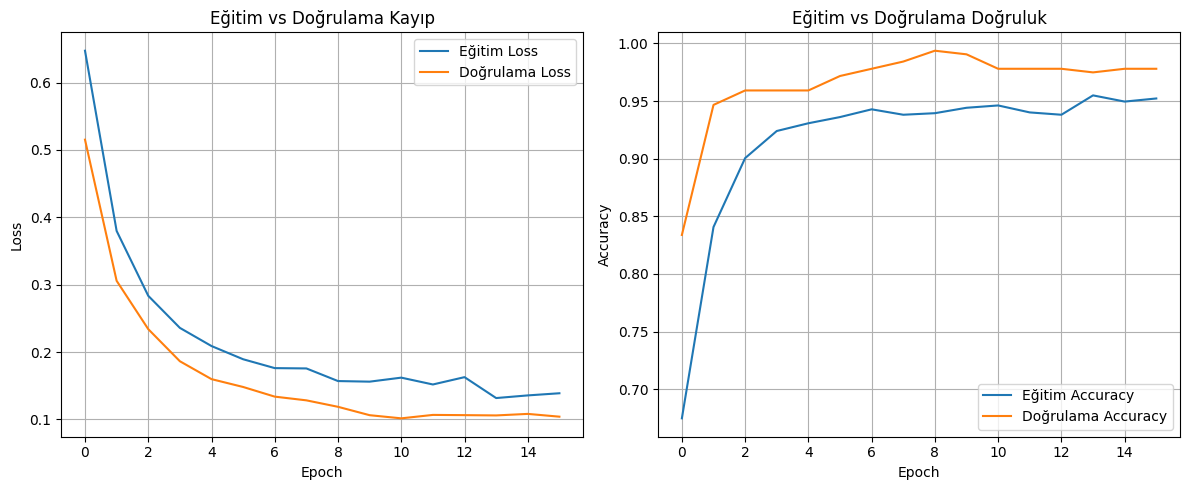

In [ ]:
import matplotlib.pyplot as plt

# Loss grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss')
plt.plot(history.history['val_loss'], label='Doğrulama Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim vs Doğrulama Kayıp')
plt.legend()
plt.grid(True)

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Accuracy')
plt.plot(history.history['val_accuracy'], label='Doğrulama Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Eğitim vs Doğrulama Doğruluk')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Found 320 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step
✅ Test doğruluğu: 98.12%

📋 Sınıflandırma Raporu:
              precision    recall  f1-score   support

    fracture       0.99      0.99      0.99       300
      normal       0.85      0.85      0.85        20

    accuracy                           0.98       320
   macro avg       0.92      0.92      0.92       320
weighted avg       0.98      0.98      0.98       320



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


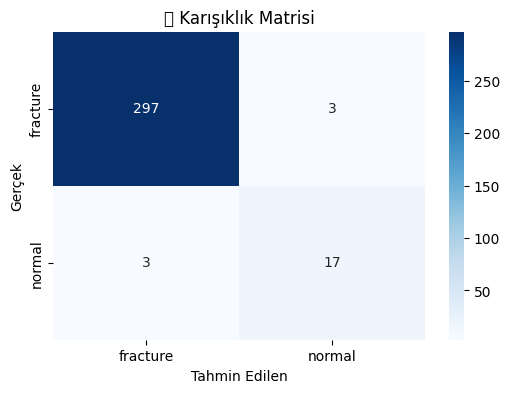

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Test seti
test_path = f"{target_dir}/test"

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Modeli yükle (finetuned modeli!)
model = load_model("/content/bone_fracture_mobilenetv2_initial.h5")

# Tahminler
predictions = model.predict(test_data)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Gerçek etiketler
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Skorlar
acc = accuracy_score(true_classes, predicted_classes)
print(f"✅ Test doğruluğu: {acc:.2%}")

print("\n📋 Sınıflandırma Raporu:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Karışıklık Matrisi
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('🔍 Karışıklık Matrisi')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🔍 Tahmin edilen sınıf: normal (92.87% güven)


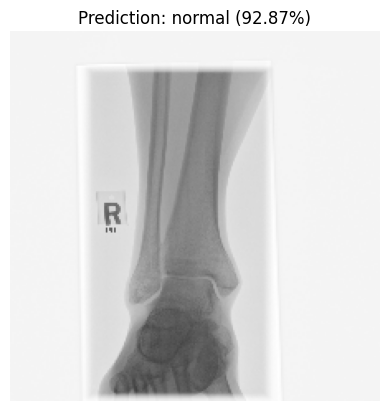

In [ ]:
# Gerekli kütüphaneler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1️⃣ Fine-tuned modeli yükle
model = load_model("/content/bone_fracture_mobilenetv2_initial.h5")  # ← kendi model dosya adınla değiştir

# 2️⃣ Test etmek istediğin görselin yolunu ver
img_path = "/content/bone-fracture-dataset/split_dataset/test/normal/92.png"  # ← buraya kendi görsel yolunu yaz

# 3️⃣ Görseli yükle ve ön işleme tabi tut
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # batch dimension ekle
img_array = preprocess_input(img_array)        # MobileNetV2 için preprocess

# 4️⃣ Tahmin yap
prediction = model.predict(img_array)[0][0]

# 5️⃣ Sonucu yorumla
class_labels = ['fracture', 'normal']  # ← Sıra önemli: 0 -> fracture, 1 -> normal
predicted_class = class_labels[int(prediction > 0.5)]
confidence = prediction if prediction > 0.5 else 1 - prediction

# 6️⃣ Sonucu yazdır
print(f"🔍 Tahmin edilen sınıf: {predicted_class} ({confidence:.2%} güven)")

# 7️⃣ Görseli göster
plt.imshow(img)
plt.title(f"Prediction: {predicted_class} ({confidence:.2%})")
plt.axis('off')
plt.show()
